In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import ipdb
from sklearn.isotonic import IsotonicRegression
import seaborn as sns
from scipy.stats import binom, norm
from tqdm import tqdm
import pandas as pd

from protein_conformal.util import *
# from util import simplifed_venn_abers_prediction

In [2]:
# conformal_pfam.npy is a len 10,000 list of dictionaries of len 10,000 hits. 
# This isn't the most valid way to do this, because it incoporates proteins from the training set into calibration. 
# We chose to do this because the previous approach didn't have enough new examples to calibrate.
data = np.load('/data/ron/protein-conformal/data/conformal_pfam_with_lookup_dataset.npy', allow_pickle=True)
print(len(data))
print(len(data[0]['S_i']))

10000
10000


## Look at distribution of $S_{ij}$ across retrieved hits

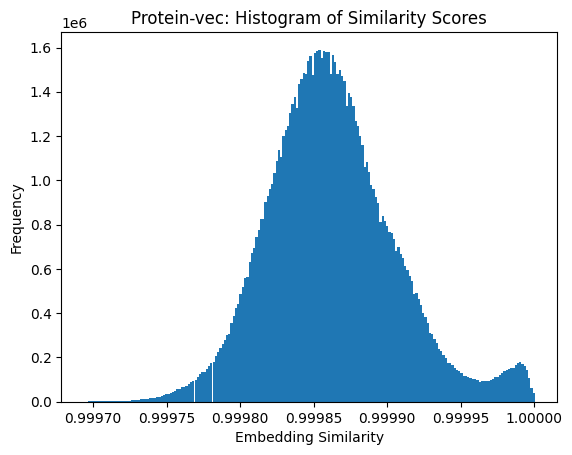

In [5]:
sims = np.stack([query['S_i'] for query in data], axis=0)
plt.hist(sims.flatten(), bins=200)
plt.xlabel('Embedding Similarity')
plt.ylabel('Frequency')
plt.title('Protein-vec: Histogram of Similarity Scores')
# plt.show()
plt.savefig('/data/ron/protein-conformal/data/pvec_histogram.pdf', format='pdf')

## FDR for exact hits on Pfam

In [6]:
# sims, labels = get_sims_labels(data, partial=False)
labels = np.stack([query['exact'] for query in data], axis=0)
sims = np.stack([query['S_i'] for query in data], axis=0)

In [7]:
lambdas = np.linspace(sims.min(),sims.max(),100)
risks = [risk(sims, labels, lam) for lam in lambdas]
risks_no_empties = [risk_no_empties(sims, labels, lam) for lam in lambdas]
# no_empties: as we increase lambda, the number of empty sets increases. We filter out the empty sets and calculate the risk.
fnr = [calculate_false_negatives(sims, labels, lam) for lam in lambdas]
# percentage_of_discoveries_rsk = [percentage_of_discoveries(sims, labels, lam) for lam in lambdas]

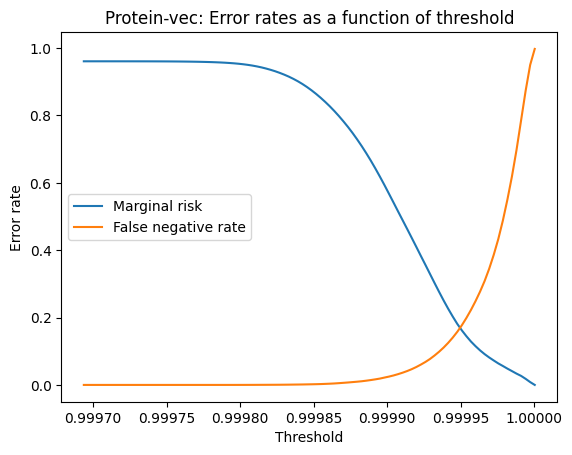

In [8]:
# Plot FDR + FNR as a function of lambda
plt.figure()
plt.plot(lambdas, risks, label='Marginal risk')
# plt.plot(lambdas, risks_no_empties, label='Risk (no empty sets)')
# plt.plot(lambdas, percentage_of_discoveries_rsk, label='Percentage of discoveries')
plt.plot(lambdas, fnr, label='False negative rate')
plt.xlabel('Threshold')
plt.ylabel('Error rate')
plt.title('Protein-vec: Error rates as a function of threshold')
plt.legend()
plt.savefig('/data/ron/protein-conformal/data/pvec_error_rates.pdf', format='pdf')

## FDR / FNR on partial hits on Pfam

In [9]:
# Plot FDR as a function of lambda
sims, labels_partial = get_sims_labels(data, partial=True)
# labels_partial = np.stack([(np.sum(query['partial'], axis=1) >= 1) if len(np.array(query['partial']).shape) > 1 else query['partial'] for query in data], axis=0)
# sims = np.stack([query['S_i'] for query in data], axis=0)
lambdas = np.linspace(sims.min(),sims.max(),100)
risks = [risk(sims, labels_partial, lam) for lam in lambdas]
risks_no_empties = [risk_no_empties(sims, labels_partial, lam) for lam in lambdas]
# no_empties: as we increase lambda, the number of empty sets increases. We filter out the empty sets and calculate the risk.
fnr = [calculate_false_negatives(sims, labels_partial, lam) for lam in lambdas]

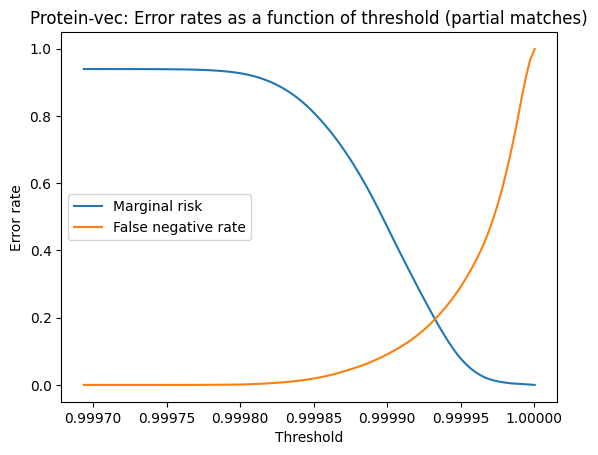

In [10]:
# Plot FDR + FNR as a function of lambda
plt.plot(lambdas, risks, label='Marginal risk')
# plt.plot(lambdas, risks_no_empties, label='Risk (no empty sets)')
# plt.plot(lambdas, percentage_of_discoveries_rsk, label='Percentage of discoveries')
plt.plot(lambdas, fnr, label='False negative rate')
plt.xlabel('Threshold')
plt.ylabel('Error rate')
plt.title('Protein-vec: Error rates as a function of threshold (partial matches)')
plt.legend()
plt.savefig('/data/ron/protein-conformal/figs/pvec_error_rates_partial.pdf', format='pdf')

## Learn then test for FDR

In [11]:
alpha = 0.1
lhat, risk = get_thresh_FDR(labels, sims, alpha, delta=0.5, N=100)
print(f'alpha={alpha}, lhat={lhat}, risk={risk}')

In [42]:
risks = []
tprs = []
lhats = []
fdr_cals = []
alpha = 0.1
num_trials = 100
n_calib = 1000
for trial in tqdm(range(num_trials)):
    np.random.shuffle(data)
    cal_data = data[:n_calib]
    test_data = data[n_calib:2*n_calib]
    X_cal, y_cal = get_sims_labels(cal_data, partial=False)
    X_test, y_test_exact = get_sims_labels(test_data, partial=False)
    # sims, labels = get_sims_labels(cal_data, partial=False)
    lhat, fdr_cal = get_thresh_FDR(y_cal, X_cal, alpha, delta=0.5, N=100)
    fdr_cals.append(fdr_cal)
    lhats.append(lhat)
    # print(X_test.shape)
    # print(y_test_exact.shape)
    risks.append(risk(X_test, y_test_exact, lhat))
    tprs.append(calculate_true_positives(X_test, y_test_exact, lhat))
    # print(lhat)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [09:34<00:00,  5.74s/it]


Text(0.5, 1.0, 'Protein-vec: True positive rates at alpha=0.1')

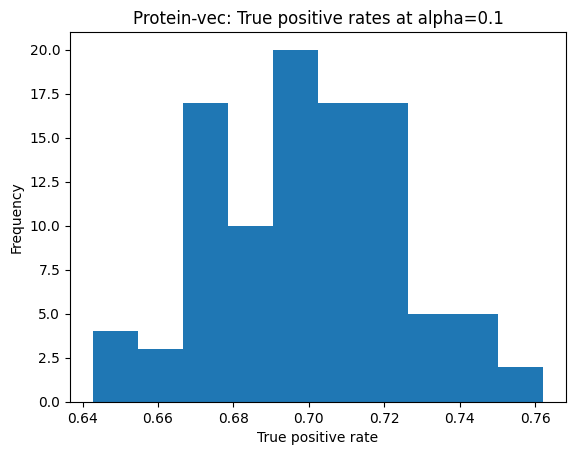

In [49]:
plt.hist(np.array(tprs))
plt.xlabel('True positive rate')
plt.ylabel('Frequency')
plt.title(f'Protein-vec: True positive rates at alpha={alpha}')

Text(0.5, 1.0, 'Protein-vec: Histogram of Thresholds')

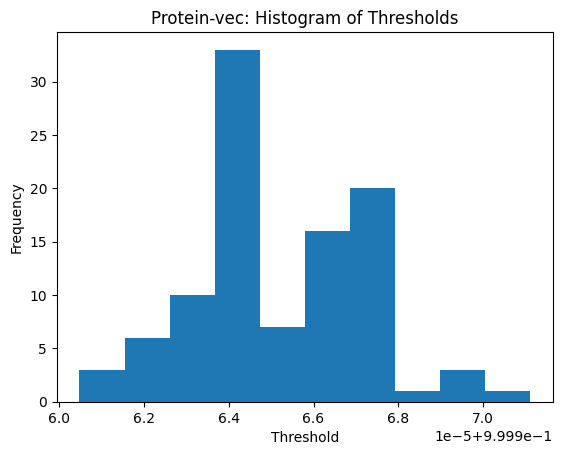

In [48]:
plt.hist(np.array(lhats))
plt.xlabel('Threshold')
plt.ylabel('Frequency')
plt.title('Protein-vec: Histogram of Thresholds')

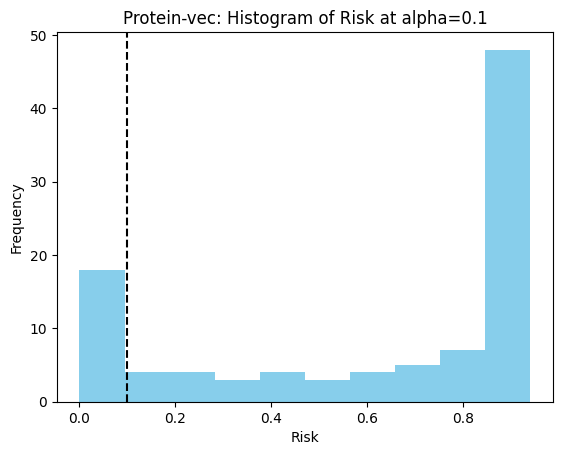

In [23]:
plt.hist(np.array(risks), label='Risk', color='skyblue')
plt.axvline(alpha, color='black', linestyle='--')
plt.xlabel('Risk')
plt.ylabel('Frequency')
plt.title(f'Protein-vec: Histogram of Risk at alpha={alpha}')
plt.savefig('/data/ron/protein-conformal/data/pvec_risk_histogram.pdf', format='pdf', bbox_inches='tight')

### FPR?

In [51]:
# is this nonsense for something else?
num_trials = 3
alpha = 0.9
n_calib = 100
for trial in range(num_trials):
    # Randomly split data into calibration and test sets
    np.random.shuffle(data)
    cal_data = data[:n_calib]
    test_data = data[n_calib:3*n_calib]

    X_cal, y_cal = get_sims_labels(cal_data, partial=False)
    X_test, y_test_exact = get_sims_labels(test_data, partial=False)
    _, y_test_partial = get_sims_labels(test_data, partial=True)
    lhat = get_thresh_new_FDR(X_cal, y_cal, alpha)
    error, fraction_inexact, error_partial, fraction_partial, false_disc = validate_lhat_new(X_test, y_test_partial, y_test_exact, lhat)
    print(f'Trial {trial+1}: lhat: {lhat}, Ex&!Id/Ex (FNR): {error:.2f}, In/Id (FDR): {fraction_inexact:.2f}, Pa&!Id/Pa (FNR partial): {error_partial:.2f}, Pa&Id/Id: {fraction_partial:.2f} (TPR partial), FPR: {false_disc:.2f}')
    

there
Trial 1: lhat: 0.9999049305915833, Ex&!Id/Ex (FNR): 0.03, In/Id (FDR): 0.75, Pa&!Id/Pa (FNR partial): 0.18, Pa&Id/Id: 0.32 (TPR partial), FPR: 0.12
there
Trial 2: lhat: 0.9999096989631653, Ex&!Id/Ex (FNR): 0.04, In/Id (FDR): 0.71, Pa&!Id/Pa (FNR partial): 0.20, Pa&Id/Id: 0.37 (TPR partial), FPR: 0.10
there
Trial 3: lhat: 0.9999082684516907, Ex&!Id/Ex (FNR): 0.04, In/Id (FDR): 0.72, Pa&!Id/Pa (FNR partial): 0.19, Pa&Id/Id: 0.36 (TPR partial), FPR: 0.10


### FNR

In [74]:
num_trials = 100
alpha = 0.1
n_calib = 100
fnrs = []
retrieved_data_percentages = []
for trial in tqdm(range(num_trials)):
    # Randomly split data into calibration and test sets
    np.random.shuffle(data)
    cal_data = data[:n_calib]
    test_data = data[n_calib:3*n_calib]

    # lhat = get_thresh_new(cal_data, alpha)
    # lhat = get_thresh(cal_data, alpha)
    # error, fraction_inexact, error_partial, fraction_partial = validate_lhat(test_data, lhat)

    # TODO: add lhat to print
    # TODO: difference between get_thresh and get_thresh_FDR
    # print(f'Trial {trial+1}: lhat: {lhat}, Ex&!Id/Ex: {error:.2f}, In/Id: {fraction_inexact:.2f}, Pa&!Id/Pa: {error_partial:.2f}, Pa&Id/Id: {fraction_partial:.2f}')

    X_cal, y_cal = get_sims_labels(cal_data, partial=False)
    X_test, y_test_exact = get_sims_labels(test_data, partial=False)
    _, y_test_partial = get_sims_labels(test_data, partial=True)
    lhat = get_thresh_new(X_cal, y_cal, alpha)
    error, fraction_inexact, error_partial, fraction_partial, fpr = validate_lhat_new(X_test, y_test_partial, y_test_exact, lhat)
    # print(f'Trial {trial+1}: lhat: {lhat}, Ex&!Id/Ex (FNR): {error:.2f}, In/Id (FDR): {fraction_inexact:.2f}, Pa&!Id/Pa (FNR partial): {error_partial:.2f}, Pa&Id/Id: {fraction_partial:.2f} (TPR partial), FPR: {fpr:.2f}')
    fnrs.append(error)
    retrieved_data_percentages.append((X_test.flatten() >= lhat).sum() / len(X_test.flatten()))
    

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:37<00:00,  2.64it/s]


Text(0.5, 1.0, 'Protein-vec: Percentage of data retrieved')

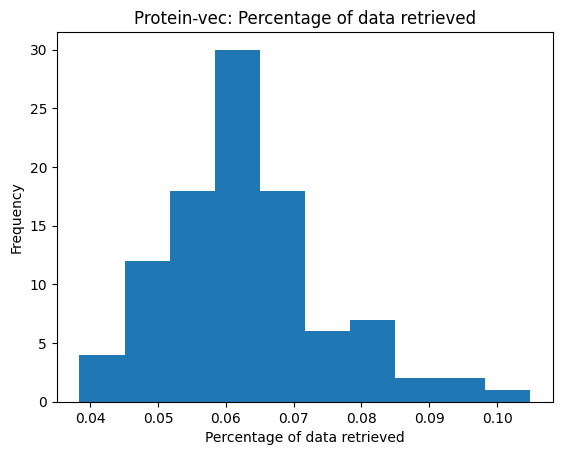

In [75]:
plt.hist(np.array(retrieved_data_percentages))
plt.xlabel('Percentage of data retrieved')
plt.ylabel('Frequency')
plt.title('Protein-vec: Percentage of data retrieved')

Text(0.5, 1.0, 'Protein-vec: False negative rates at alpha=0.1')

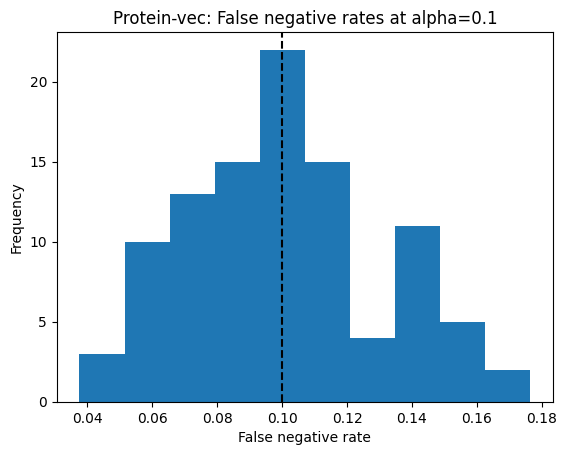

In [58]:
plt.hist(np.array(fnrs))
plt.axvline(alpha, color='black', linestyle='--')
plt.xlabel('False negative rate')
plt.ylabel('Frequency')
plt.title(f'Protein-vec: False negative rates at alpha={alpha}')


## Venn-Abers prediction

In [117]:
n_calib = 50

np.random.shuffle(data)
cal_data = data[:n_calib]
test_data = data[n_calib:3*n_calib]


X_cal, y_cal = get_sims_labels(cal_data, partial=False)
X_test, y_test_exact = get_sims_labels(test_data, partial=False)
# flatten the data
X_cal = X_cal.flatten()
y_cal = y_cal.flatten()
X_test = X_test.flatten()
y_test_exact = y_test_exact.flatten()


# np.random.shuffle(data)
# X_cal = sims[:n_calib, :].flatten()
# y_cal = labels[:n_calib].flatten()
# cal_data = data[:n_calib]
# X_test = sims[n_calib:2*n_calib, :].flatten()
# y_test = labels[n_calib:2*n_calib].flatten()
# test_data = data[n_calib:3*n_calib]
# ir = get_isotone_regression(cal_data)
# sims, labels = get_sims_labels(test_data, partial=False)
p_0, p_1 = simplifed_venn_abers_prediction(X_cal, y_cal, X_test[0])


In [118]:
p_0, p_1

(1.0, 0.99908924)

In [14]:
def run_trial(data, n_calib):
    np.random.shuffle(data)
    cal_data = data[:n_calib]
    test_data = data[n_calib:3*n_calib]
    X_cal, y_cal = get_sims_labels(cal_data, partial=False)
    X_test, y_test_exact = get_sims_labels(test_data, partial=False)
    # flatten the data
    X_cal = X_cal.flatten()
    y_cal = y_cal.flatten()
    X_test = X_test.flatten()
    y_test_exact = y_test_exact.flatten()

    # generate random indices in the test set
    i = np.random.randint(0, len(X_test))
    # i_s = np.random.randint(0, len(X_test), int(len(X_test) * args.percent_sva_test))

    p_0, p_1 = simplifed_venn_abers_prediction(X_cal, y_cal, X_test[i])
    result = (p_0, p_1, X_test[i], y_test_exact[i])
    return result

num_trials = 1000
sva_results = []
n_calib = 50
for trial in tqdm(range(num_trials)):
    # print(f'Running trial {i+1} of {args.num_trials}')
    sva_results.append(run_trial(data, n_calib))

# sva_results = []
# # generate random indices in the test set
# i_s = np.random.randint(0, len(X_test), 10000)

# for _, i in tqdm(enumerate(i_s)):
#     p_0, p_1 = simplifed_venn_abers_prediction(X_cal, y_cal, X_test[i])
#     sva_results.append((p_0, p_1, y_test_exact[i]))
    # print(f'Prediction: {p_1}, Actual: {y_test[i]}')

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [05:14<00:00,  3.18it/s]


In [15]:
abs_p = [np.abs(p[0] - p[1]) for p in sva_results]

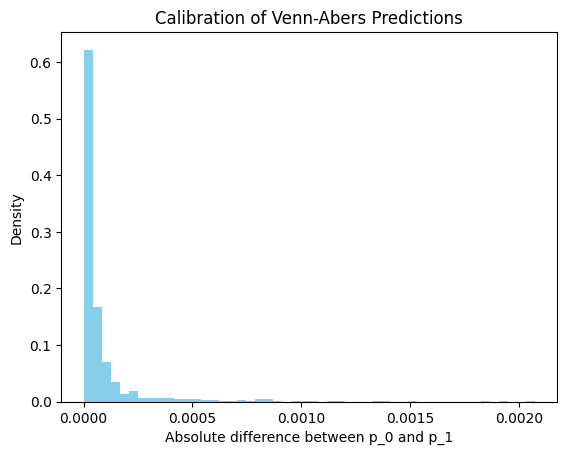

In [22]:
weights = np.ones_like(abs_p) / len(abs_p)
plt.hist(abs_p, bins=50, color='skyblue', weights=weights)
plt.xlabel('Absolute difference between p_0 and p_1')
plt.ylabel('Density')
plt.title('Calibration of Venn-Abers Predictions')
plt.savefig('/data/ron/protein-conformal/figs/sva_calibration.pdf', format='pdf')

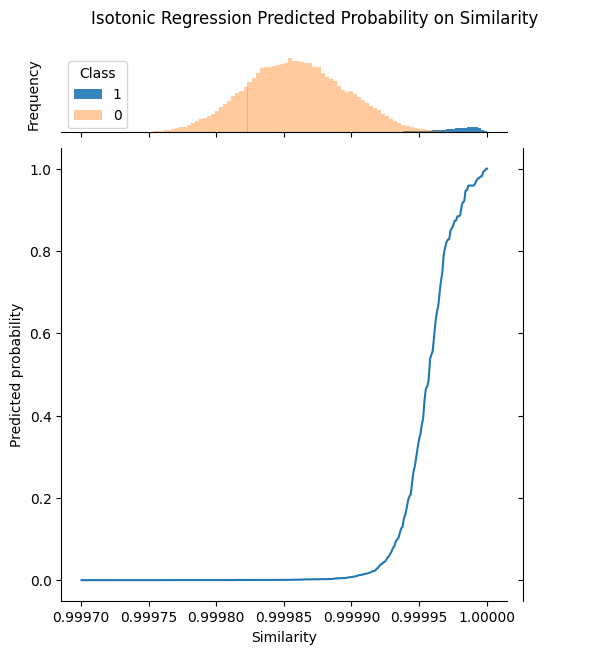

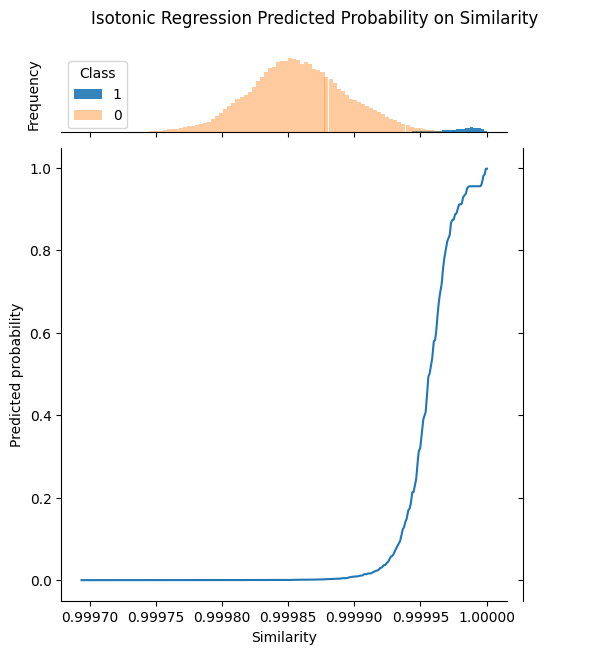

In [51]:
num_trials = 2
n_calib = 1200
for trial in range(num_trials):
    # Randomly split data into calibration and test sets
    np.random.shuffle(data)
    cal_data = data[:n_calib]
    test_data = data[n_calib:2*n_calib]
    X_cal, y_cal = get_sims_labels(cal_data, partial=False)
    ir = get_isotone_regression(X_cal.flatten(), y_cal.flatten())
    X_test, y_test = get_sims_labels(test_data, partial=False)
    preds = ir.predict(X_test.flatten())
    g = sns.JointGrid()
    # g.ax_joint.scatter(X_test[y_test], y_test[y_test], alpha=0.002)
    # g.ax_joint.scatter(X_test[~y_test], y_test[~y_test], alpha=0.002)
    x = np.linspace(np.min(X_test), np.max(X_test), 1000)
    phats = ir.predict(x)
    g.ax_joint.plot(x, phats)
    g.set_axis_labels('Similarity', 'Predicted probability')

    g.ax_marg_x.hist(X_test[y_test], label='1', alpha=0.9, bins=100)
    g.ax_marg_x.hist(X_test[~y_test], label='0', alpha=0.4, bins=100)
    # Manually create a new axis for the marginal histogram and set its y-axis label
    ax_marg_y = g.figure.add_axes(g.ax_marg_x.get_position())
    ax_marg_y.yaxis.tick_right()
    ax_marg_y.set_ylabel('Frequency', labelpad=15)
    ax_marg_y.yaxis.set_label_position('left')
    ax_marg_y.set_yticks([])
    ax_marg_y.set_frame_on(False)
    ax_marg_y.set_xticks([])

    handles, labels = g.ax_marg_x.get_legend_handles_labels()
    g.ax_marg_x.legend(handles, labels, title='Class')

    # Optionally remove the spines for a cleaner look
    # g.ax_marg_x.spines['bottom'].set_visible(False)
    # g.ax_marg_x.spines['top'].set_visible(False)
    # g.ax_marg_x.spines['left'].set_visible(False)
    # g.ax_marg_x.spines['right'].set_visible(False)
    
    plt.suptitle('Isotonic Regression Predicted Probability on Similarity', y=1.05)
    plt.show()
    plt.show()
    
    ##print()
    #plt.figure()
    #sim_bins = np.linspace(min(sims), max(sims), 100)
    #plt.hist(np.array(sims)[np.array(labels)], bins=sim_bins, alpha=0.5, label='1')
    #plt.hist(np.array(sims)[~np.array(labels)], bins=sim_bins, alpha=0.5, label='0')
    #plt.legend()

    

## Scratch

In [ ]:
np.argmax([sum(query['exact'])/len(query['exact']) for query in data])

In [ ]:
sum(data[843]['exact'])

In [ ]:
np.median([sum(query['exact'])/len(query['exact']) for query in data])

In [ ]:
# rename the D_i key in data to S_i and save the file
for i in range(len(data)):
    data[i]['S_i'] = data[i].pop('D_i')
np.save('/data/ron/protein-conformal/data/conformal_pfam.npy', data)

In [ ]:
# conformal_pfam.npy is a len 1864 list of dictionaries of len 1000. 
# We stopped using this because for some proteins, every retreived hit was a true positive.
# TODO: can remake this dataset with 10000 retrieved hits per protein. 
# This is more accurate than the solution after, which samples generally from the lookup set instead.

data = np.load('/data/ron/protein-conformal/data/conformal_pfam.npy', allow_pickle=True)
len(data)

1864

In [ ]:
data[0].keys()

dict_keys(['meta', 'meta_query', 'exact', 'partial', 'D_i'])

'meta': these are the Pfam (protein family) entries from the lookup dataset. Len 1000

'meta_query': this is the Pfam of the query protein (there is only one per dict). Some proteins will have multiple pfams associated with them

'exact': True if the meta_query Pfam is in any of the Pfams for meta. Len 1000

'partial': In the case where a query protein is assigned multiple Pfams, we seek to see if we get partial hits for each of these query protein Pfams. Shape 1000 x # of Pfams for query protein

D_i: These are the similarities assigned by our model for each query to its top 1000 lookup pairs (len 1000 as well)

(array([  2069.,  12248.,  38818., 133427., 247517., 230022., 159742.,
         97177.,  23181.,   1361.]),
 array([0.99980909, 0.99982811, 0.99984714, 0.99986616, 0.99988519,
        0.99990422, 0.99992324, 0.99994227, 0.99996129, 0.99998032,
        0.99999934]),
 <BarContainer object of 10 artists>)

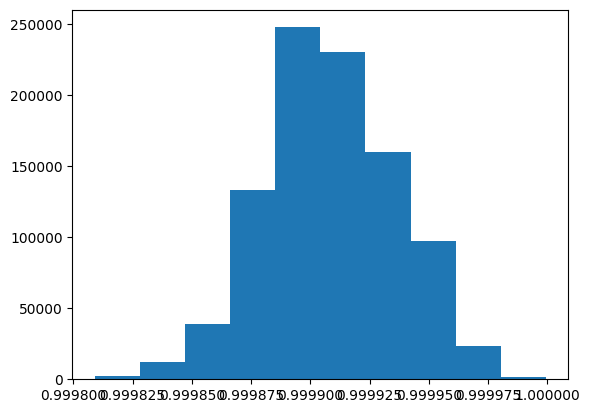

In [ ]:
plt.hist(np.array(sims)[~np.array(labels).astype(bool)])

In [ ]:
ir.predict(sims)

array([1.00000000e+00, 1.00000000e+00, 9.11538462e-01, ...,
       2.08751924e-04, 2.08751924e-04, 2.08751924e-04])

In [ ]:
ir.predict([.5])

array([0.])

In [ ]:
# I believe this was to look at the histogram of 
sims, labels = get_sims_labels(test_data, partial=False)
plt.hist(np.array(sims)[np.array(labels).astype(bool)])

KeyError: 'D_i'

In [ ]:
max_sim_exact = []
for i in range(len(data[0]['exact'])):
    idx = data[0]['exact'][i]
    sims = data[0]['S_i'][i]

    max_sim = sims[idx]
    max_sim_exact.append(max(sims[idx]))

ValueError: max() arg is an empty sequence

In [ ]:
    # for lookup in query['exact']:
    #     sims = query['D_i']
    #     all_sim_exact.append(sims[lookup])

# for i in range(len(data['exact'])):
#     idx = data['exact'][i]
#     sims = data['D_i'][i]
#     sims_to_append = sims[idx]
#     # if len(sims_to_append) == 0:
#     #     sims_to_append = np.nan
#     all_sim_exact.append(sims_to_append)

In [ ]:
sims[:n_calib, :].shape

(50, 10000)

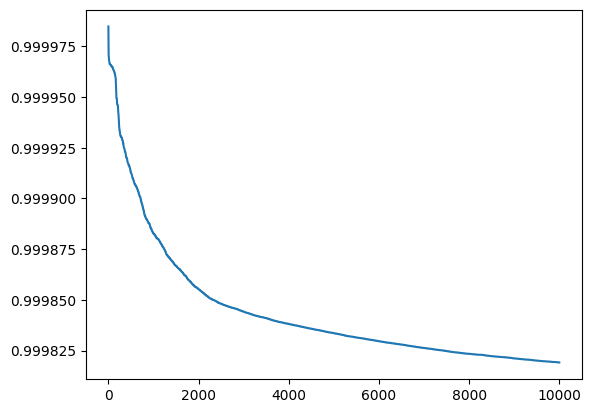

In [ ]:
plt.plot(sims[:n_calib, :][0])

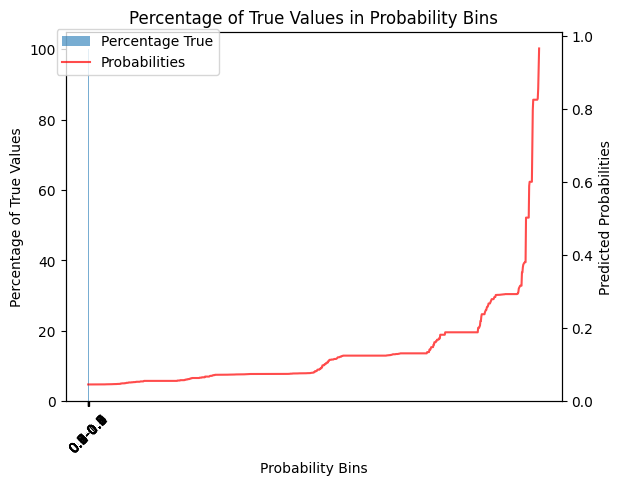

In [ ]:


# Assuming sva_results is a list of tuples (prediction, actual)
sva_results_2 = [(x[1], x[2]) for x in sva_results]  # Replace with actual results

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(sva_results_2, columns=['probability', 'actual'])

# Define bins for the probabilities
bins = np.arange(0, 1.1, 0.1)  # Bins from 0 to 1 with step of 0.1

# Assign each probability to a bin
df['bin'] = pd.cut(df['probability'], bins, include_lowest=True)

# Calculate the percentage of true values within each bin
bin_stats = df.groupby('bin')['actual'].agg(['mean', 'count'])
bin_stats['percentage_true'] = bin_stats['mean'] * 100

# Plot the bar chart for the percentage of true values
fig, ax1 = plt.subplots()

bin_centers = bins[:-1] + 0.05  # Center of each bin for plotting

ax1.bar(bin_centers, bin_stats['percentage_true'], width=0.1, alpha=0.6, label='Percentage True')
ax1.set_xlabel('Probability Bins')
ax1.set_ylabel('Percentage of True Values')
ax1.set_title('Percentage of True Values in Probability Bins')
ax1.set_xticks(bin_centers)
ax1.set_xticklabels([f'{b:.1f}-{b+0.1:.1f}' for b in bins[:-1]], rotation=45)

# Plot the line chart for the sorted predicted probabilities
# sorted_probabilities = df['probability'].sort_values().reset_index(drop=True)
# ax2 = ax1.twinx()
# ax2.plot(sorted_probabilities, label='Probabilities', color='red', alpha=0.7)
# ax2.set_ylabel('Predicted Probabilities')

# # Add legends
# fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# plt.show()


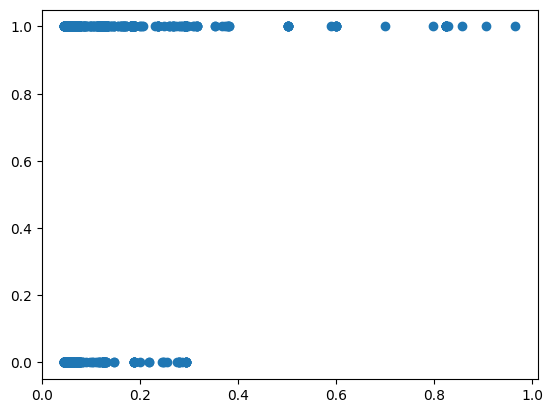

In [ ]:
plt.plot(df_sva['p'], df_sva['y'], 'o')

In [ ]:
len(y_test_exact[i_s])

10000

In [ ]:
sum(y_test_exact[i_s])

380

In [ ]:
df_sva = pd.DataFrame(sva_results, columns=['p_0', 'p_1', 'y'])
# mean value of p_0 and p_1
df_sva['p'] = df_sva[['p_0', 'p_1']].mean(axis=1)


In [ ]:
df_sva.head()

,p_0,p_1,y,p,p_bin
0,0.965522,0.965359,True,0.965440,"(0.873, 0.965]"
1,0.905682,0.905285,True,0.905484,"(0.873, 0.965]"
2,0.857319,0.855731,True,0.856525,"(0.781, 0.873]"
3,0.828416,0.828299,True,0.828358,"(0.781, 0.873]"
4,0.825133,0.825000,True,0.825066,"(0.781, 0.873]"


In [ ]:
# make bins for p
df_sva['p_bin'] = pd.cut(df_sva['p'], bins=10)


In [ ]:
df_sva.groupby('p_bin')['y'].sum()

p_bin
(-0.000994, 0.1]     69
(0.1, 0.2]           17
(0.2, 0.3]            7
(0.3, 0.4]           28
(0.4, 0.5]            2
(0.5, 0.6]            7
(0.6, 0.7]           10
(0.7, 0.8]           10
(0.8, 0.9]           21
(0.9, 1.0]          209
Name: y, dtype: int64

In [ ]:
# show size of each bin
df_sva.groupby('p_bin').size()

p_bin
(-0.000994, 0.1]    9546
(0.1, 0.2]            69
(0.2, 0.3]            20
(0.3, 0.4]            66
(0.4, 0.5]             5
(0.5, 0.6]             9
(0.6, 0.7]            13
(0.7, 0.8]            12
(0.8, 0.9]            25
(0.9, 1.0]           235
dtype: int64

In [ ]:
# calculate the mean of y for each bin
df_sva.groupby('p_bin')['y'].mean()

p_bin
(-0.000994, 0.1]    0.007228
(0.1, 0.2]          0.246377
(0.2, 0.3]          0.350000
(0.3, 0.4]          0.424242
(0.4, 0.5]          0.400000
(0.5, 0.6]          0.777778
(0.6, 0.7]          0.769231
(0.7, 0.8]          0.833333
(0.8, 0.9]          0.840000
(0.9, 1.0]          0.889362
Name: y, dtype: float64

In [ ]:
df_sva.to_csv('/data/ron/protein-conformal/data/sva_results_1.csv')

Text(0.5, 1.0, 'Protein-vec: Predicted probabilities of being a positive')

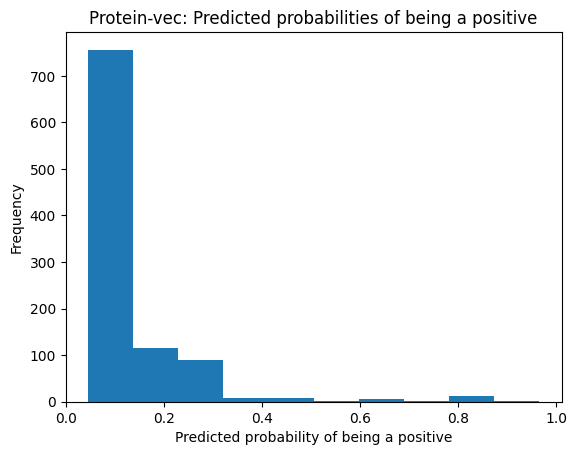

In [ ]:
# plot the probabilities and the percentage of correct predictions
p_1s = np.array([result[1] for result in sva_results])
actuals = np.array([result[2] for result in sva_results])
plt.hist(p_1s)
plt.xlabel('Predicted probability of being a positive')
plt.ylabel('Frequency')
plt.title('Protein-vec: Predicted probabilities of being a positive')


In [ ]:

# preds = ir.predict(sims)
# g = sns.JointGrid()
# g.ax_joint.scatter(sims, labels, alpha=0.003)
# x = np.linspace(min(sims), max(sims), 1000)
# phats = ir.predict(x)
# g.ax_joint.plot(x, phats)
# g.ax_marg_x.hist(np.array(sims)[np.array(labels)], label='1', alpha=0.5)
# g.ax_marg_x.hist(np.array(sims)[~np.array(labels)], label='0', alpha=0.5)
# plt.show()

In [ ]:
p_0, p_1

(0.9655216, 0.96535933)